# Task 5 · Traffic Sign Recognition — Data Exploration

This notebook explores the GTSRB dataset structure, class balance, and image quality to inform preprocessing and model design.

Goals:
- Load dataset metadata (Train.csv, Test.csv, Meta.csv)
- Class distribution analysis (imbalance, counts)
- Visualize sample images from each class
- Data quality assessment (missing files, ROI validity, image sizes)

Notes:
- Paths are resolved relative to the project root.
- Heavy checks default to sampling for speed; you can enable full checks later.

In [30]:
# Imports and paths
from pathlib import Path
import os
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Plot style
sns.set_theme(style="whitegrid")
%matplotlib inline

# Resolve project paths
PROJECT_ROOT = Path(__file__).resolve().parents[2] if '__file__' in globals() else Path.cwd().parents[0]
DATA_PATH = PROJECT_ROOT / "data" / "raw"
TRAIN_CSV = DATA_PATH / "Train.csv"
TEST_CSV = DATA_PATH / "Test.csv"
META_CSV = DATA_PATH / "Meta.csv"
TRAIN_IMG_DIR = DATA_PATH / "Train"
TEST_IMG_DIR = DATA_PATH / "Test"
META_IMG_DIR = DATA_PATH / "Meta"

paths_to_check = [TRAIN_CSV, TEST_CSV, META_CSV, TRAIN_IMG_DIR, TEST_IMG_DIR, META_IMG_DIR]
for path in paths_to_check:
    print(f"{path}: {'OK' if path.exists() else 'MISSING'}")

f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Train.csv: OK
f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Test.csv: OK
f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Meta.csv: OK
f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Train: OK
f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Test: OK
f:\VsCodeFolders\Work_Elevvo\Task_5\data\raw\Meta: OK


In [31]:
# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
meta_df = pd.read_csv(META_CSV)

summary_stats = {
    'train_rows': len(train_df),
    'test_rows': len(test_df),
    'meta_rows': len(meta_df),
    'train_cols': list(train_df.columns),
    'test_cols': list(test_df.columns),
    'meta_cols': list(meta_df.columns),
}
summary_stats

{'train_rows': 39209,
 'test_rows': 12630,
 'meta_rows': 43,
 'train_cols': ['Width',
  'Height',
  'Roi.X1',
  'Roi.Y1',
  'Roi.X2',
  'Roi.Y2',
  'ClassId',
  'Path'],
 'test_cols': ['Width',
  'Height',
  'Roi.X1',
  'Roi.Y1',
  'Roi.X2',
  'Roi.Y2',
  'ClassId',
  'Path'],
 'meta_cols': ['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']}

Total classes: 43
Imbalance ratio (max/min): 10.71


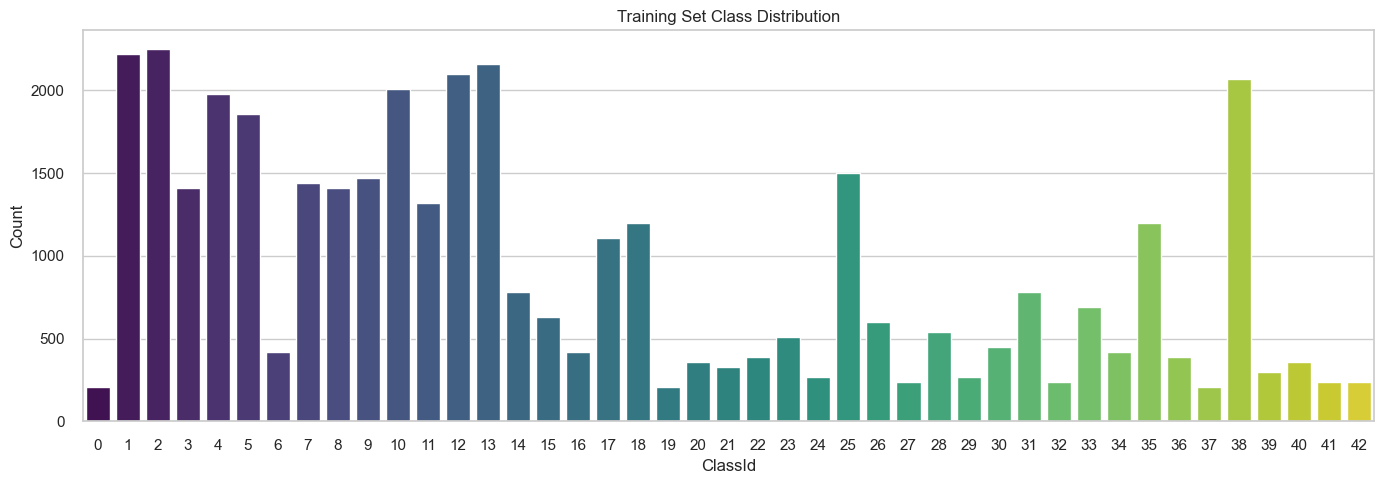

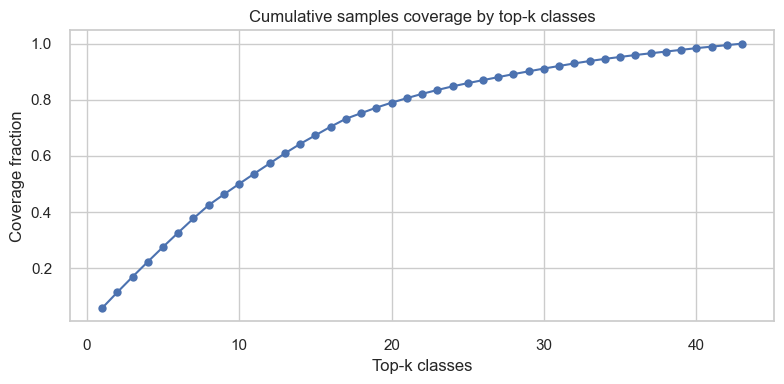

In [32]:
# Class distribution analysis
class_counts = train_df['ClassId'].value_counts().sort_index()
imbalance_ratio = class_counts.max() / class_counts.min()

total_classes = class_counts.shape[0]
print(f"Total classes: {total_classes}")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax, palette="viridis")
ax.set_title("Training Set Class Distribution")
ax.set_xlabel("ClassId")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Cumulative coverage plot
cumulative = class_counts.sort_values(ascending=False).cumsum() / class_counts.sum()
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, total_classes + 1), cumulative.values, marker='o')
ax.set_title("Cumulative samples coverage by top-k classes")
ax.set_xlabel("Top-k classes")
ax.set_ylabel("Coverage fraction")
ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Sample images per class (one per unique class, up to 49)
from math import ceil

unique_classes = sorted(train_df['ClassId'].unique().tolist())
N = min(49, len(unique_classes))
selected_classes = unique_classes[:N]

grid_size = ceil(np.sqrt(N))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2.6, grid_size*2.6))
axes = axes.flatten()

for i, cls in enumerate(selected_classes):
    ax = axes[i]
    sample = train_df[train_df.ClassId == cls].head(1)
    if sample.empty:
        ax.axis('off')
        continue
    row = sample.iloc[0]
    rel_path = row['Path']
    img_path = DATA_PATH / rel_path
    try:
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        # draw ROI rectangle if within image bounds
        x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=1))
        ax.set_title(f"Class {cls}", fontsize=8)
        ax.axis('off')
    except FileNotFoundError:
        ax.text(0.5, 0.5, 'Missing', ha='center', va='center')
        ax.set_title(f"Class {cls}", fontsize=8)
        ax.axis('off')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample images per class (with ROI)', y=0.95)
plt.tight_layout()
plt.show()

In [33]:
# Data quality checks
quality_report = {}

# 1) Missing files in Train
train_paths = train_df['Path'].apply(lambda p: DATA_PATH / p)
missing_train = [str(p) for p in train_paths if not p.exists()]
quality_report['missing_train_files'] = len(missing_train)

# 2) Duplicate image paths
quality_report['duplicate_train_paths'] = int(train_df['Path'].duplicated().sum())

# 3) ROI validity (x2>x1, y2>y1 and within width/height)
def roi_valid(row):
    x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.Y2']), int(row['Roi.Y2'])
    # Fix: we need correct mapping; recalc below
    x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
    w, h = int(row['Width']), int(row['Height'])
    return (x2 > x1) and (y2 > y1) and (0 <= x1 < x2 <= w) and (0 <= y1 < y2 <= h)

valid_roi = train_df.apply(roi_valid, axis=1)
quality_report['invalid_roi_count'] = int((~valid_roi).sum())
quality_report['roi_valid_rate'] = float(valid_roi.mean())

# 4) Quick image open and size distribution (sampled for speed)
sample_n = min(2000, len(train_df))
sample_df = train_df.sample(sample_n, random_state=42)

sizes = []
open_errors = 0
for _, r in sample_df.iterrows():
    p = DATA_PATH / r['Path']
    try:
        with Image.open(p) as im:
            sizes.append(im.size)  # (W,H)
    except Exception:
        open_errors += 1

if sizes:
    ws, hs = zip(*sizes)
    img_props = pd.DataFrame({'W': ws, 'H': hs})
    quality_report['img_open_errors_sample'] = int(open_errors)
    quality_report['img_W_mean_std'] = (float(img_props['W'].mean()), float(img_props['W'].std()))
    quality_report['img_H_mean_std'] = (float(img_props['H'].mean()), float(img_props['H'].std()))
else:
    quality_report['img_open_errors_sample'] = int(open_errors)

quality_report

{'missing_train_files': 0,
 'duplicate_train_paths': 0,
 'invalid_roi_count': 0,
 'roi_valid_rate': 1.0,
 'img_open_errors_sample': 0,
 'img_W_mean_std': (49.45, 22.227922536083643),
 'img_H_mean_std': (49.071, 21.40483689546035)}

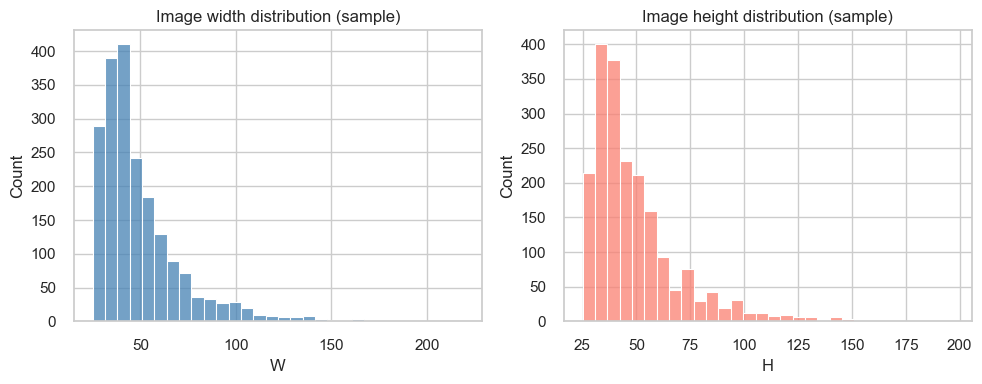

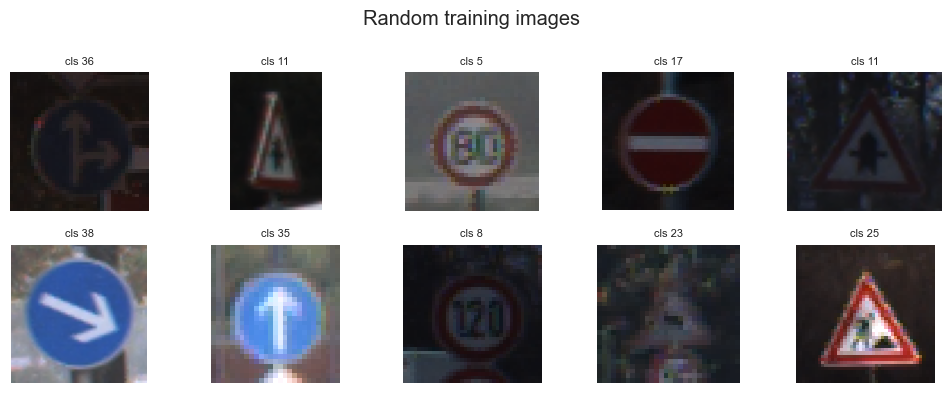

In [34]:
# Image size distribution and random samples
if 'img_props' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(img_props['W'], bins=30, ax=axes[0], color='steelblue')
    axes[0].set_title('Image width distribution (sample)')
    sns.histplot(img_props['H'], bins=30, ax=axes[1], color='salmon')
    axes[1].set_title('Image height distribution (sample)')
    plt.tight_layout()
    plt.show()

# Show a few random images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
for i, (_, r) in enumerate(train_df.sample(10, random_state=123).iterrows()):
    p = DATA_PATH / r['Path']
    try:
        img = Image.open(p).convert('RGB')
        axes[i].imshow(img)
        axes[i].set_title(f"cls {r['ClassId']}", fontsize=8)
        axes[i].axis('off')
    except Exception:
        axes[i].text(0.5, 0.5, 'ERR', ha='center', va='center')
        axes[i].axis('off')
plt.suptitle('Random training images')
plt.tight_layout()
plt.show()

## Enhanced EDA Overview and KPIs

We extend the analysis with class imbalance metrics, image/ROI quality diagnostics, train–test distribution shifts, and a brief executive summary with recommendations.

In [35]:
# Advanced class imbalance metrics
counts = class_counts.values.astype(float)
cv = counts.std() / counts.mean()
# Gini coefficient for distribution inequality
sorted_counts = np.sort(counts)
index = np.arange(1, len(sorted_counts) + 1)
gini = (np.sum((2 * index - len(sorted_counts) - 1) * sorted_counts)) / (len(sorted_counts) * np.sum(sorted_counts))

class_analysis = (
    class_counts.rename('count')
    .reset_index()
    .rename(columns={'index': 'ClassId'})
    .assign(freq=lambda d: d['count'] / d['count'].sum())
    .sort_values('count', ascending=False)
)

print({
    'classes': len(class_counts),
    'imbalance_ratio_max_min': float(imbalance_ratio),
    'cv': float(cv),
    'gini': float(gini),
    'top_overrepresented': class_analysis.head(5).to_dict(orient='records'),
    'top_underrepresented': class_analysis.tail(5).to_dict(orient='records'),
})

{'classes': 43, 'imbalance_ratio_max_min': 10.714285714285714, 'cv': 0.754211117047367, 'gini': 0.41242073634019716, 'top_overrepresented': [{'ClassId': 2, 'count': 2250, 'freq': 0.05738478410569002}, {'ClassId': 1, 'count': 2220, 'freq': 0.05661965365094749}, {'ClassId': 13, 'count': 2160, 'freq': 0.05508939274146242}, {'ClassId': 12, 'count': 2100, 'freq': 0.05355913183197735}, {'ClassId': 38, 'count': 2070, 'freq': 0.05279400137723482}], 'top_underrepresented': [{'ClassId': 27, 'count': 240, 'freq': 0.006121043637940269}, {'ClassId': 41, 'count': 240, 'freq': 0.006121043637940269}, {'ClassId': 0, 'count': 210, 'freq': 0.005355913183197735}, {'ClassId': 19, 'count': 210, 'freq': 0.005355913183197735}, {'ClassId': 37, 'count': 210, 'freq': 0.005355913183197735}]}


{'roi_area_mean': 1966.080287689051, 'roi_area_median': 1056.0, 'roi_frac_mean': 0.5618988526044275, 'roi_frac_5th_95th': (0.3931034482758621, 0.6912156166814551), 'out_of_bounds_rate': 0.0, 'tiny_roi_rate': 0.0}


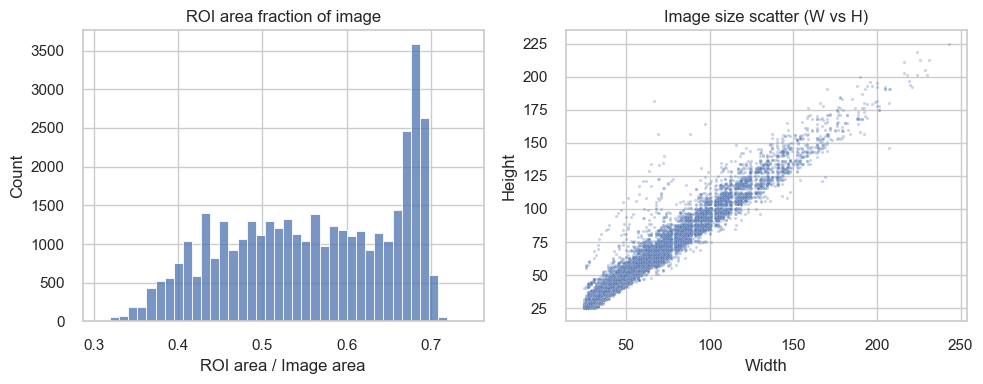

In [36]:
# ROI and image quality insights
roi_w = (train_df['Roi.X2'] - train_df['Roi.X1']).clip(lower=0)
roi_h = (train_df['Roi.Y2'] - train_df['Roi.Y1']).clip(lower=0)
roi_area = roi_w * roi_h
img_area = train_df['Width'] * train_df['Height']
roi_frac = (roi_area / img_area).replace([np.inf, -np.inf], np.nan)

out_of_bounds = (
    (train_df['Roi.X1'] < 0) | (train_df['Roi.Y1'] < 0) |
    (train_df['Roi.X2'] > train_df['Width']) | (train_df['Roi.Y2'] > train_df['Height'])
)

tiny_roi = roi_area < 10  # arbitrary threshold; tweak as needed

roi_summary = {
    'roi_area_mean': float(np.nanmean(roi_area)),
    'roi_area_median': float(np.nanmedian(roi_area)),
    'roi_frac_mean': float(np.nanmean(roi_frac)),
    'roi_frac_5th_95th': (float(np.nanpercentile(roi_frac, 5)), float(np.nanpercentile(roi_frac, 95))),
    'out_of_bounds_rate': float(out_of_bounds.mean()),
    'tiny_roi_rate': float(tiny_roi.mean()),
}
print(roi_summary)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(roi_frac.replace([np.inf, -np.inf], np.nan).dropna(), bins=40, ax=axes[0])
axes[0].set_title('ROI area fraction of image')
axes[0].set_xlabel('ROI area / Image area')

sns.scatterplot(x=train_df['Width'], y=train_df['Height'], s=5, alpha=0.3, ax=axes[1])
axes[1].set_title('Image size scatter (W vs H)')
plt.tight_layout()
plt.show()

{'KL_divergence_train_test': 0.0022436176483166684, 'chi_square_like': 0.004712821957566587}
Top-10 class proportion shifts:
    ClassId  train_prop  test_prop  abs_diff
5         5    0.047438   0.049881  0.002443
40       40    0.009182   0.007126  0.002056
20       20    0.009182   0.007126  0.002056
2         2    0.057385   0.059382  0.001998
13       13    0.055089   0.057007  0.001918
28       28    0.013772   0.011876  0.001896
38       38    0.052794   0.054632  0.001838
4         4    0.050499   0.052257  0.001758
31       31    0.019893   0.021378  0.001484
14       14    0.019893   0.021378  0.001484


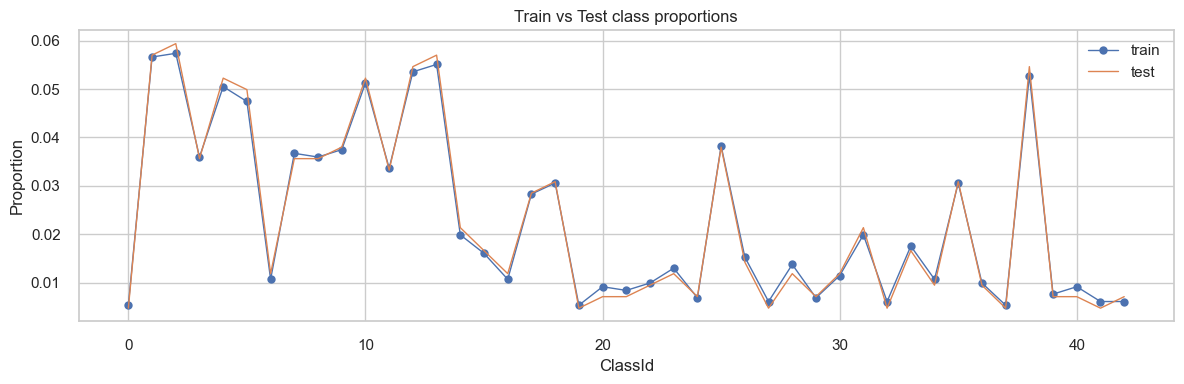

In [37]:
# Train–Test distribution comparison
train_prop = train_df['ClassId'].value_counts(normalize=True).sort_index()
test_prop = test_df['ClassId'].value_counts(normalize=True).sort_index()

# Align indexes
all_classes = sorted(set(train_prop.index).union(set(test_prop.index)))
train_p = train_prop.reindex(all_classes, fill_value=0).values + 1e-12
test_q = test_prop.reindex(all_classes, fill_value=0).values + 1e-12

kl = np.sum(train_p * np.log(train_p / test_q))  # KL(train || test)
chi_sq = np.sum((train_p - test_q) ** 2 / (test_q + 1e-12))

shift = pd.DataFrame({
    'ClassId': all_classes,
    'train_prop': train_p,
    'test_prop': test_q,
    'abs_diff': np.abs(train_p - test_q)
}).sort_values('abs_diff', ascending=False)

print({'KL_divergence_train_test': float(kl), 'chi_square_like': float(chi_sq)})
print('Top-10 class proportion shifts:')
print(shift.head(10))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(all_classes, train_p, label='train', marker='o', linewidth=1)
ax.plot(all_classes, test_q, label='test', marker='x', linewidth=1)
ax.set_title('Train vs Test class proportions')
ax.set_xlabel('ClassId')
ax.set_ylabel('Proportion')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Duplicate detection and potential leakage check (lightweight)
from hashlib import md5

# Sample hashing for speed
hash_sample = train_df.sample(min(5000, len(train_df)), random_state=7)

def file_md5(p):
    try:
        with open(p, 'rb') as f:
            return md5(f.read()).hexdigest()
    except Exception:
        return None

hashes = hash_sample['Path'].apply(lambda rel: file_md5(DATA_PATH / rel))
dup_rate = 1.0 - hashes.nunique() / hashes.notna().sum() if hashes.notna().sum() else 0.0

# Simple leakage heuristic: overlapping filenames between Train and Test
train_files = set(train_df['Path'].apply(lambda x: Path(x).name))
test_files = set(test_df['Path'].apply(lambda x: Path(x).name))
filename_intersection = train_files.intersection(test_files)

print({'duplicate_hash_rate_sample': float(dup_rate), 'train_test_filename_overlap': len(filename_intersection)})

{'duplicate_hash_rate_sample': 0.0, 'train_test_filename_overlap': 0}


In [39]:
# Executive summary and recommendations
analysis_results = {}

# Collect key metrics from previous cells safely
try:
    analysis_results['n_train'] = len(train_df)
    analysis_results['n_test'] = len(test_df)
    analysis_results['n_classes'] = int(total_classes)
    analysis_results['imbalance_ratio'] = float(imbalance_ratio)
    analysis_results['cv'] = float(cv)
    analysis_results['gini'] = float(gini)
    analysis_results['missing_train_files'] = int(quality_report.get('missing_train_files', -1))
    analysis_results['roi_valid_rate'] = float(quality_report.get('roi_valid_rate', np.nan))
    analysis_results['tiny_roi_rate'] = float(tiny_roi.mean()) if 'tiny_roi' in globals() else np.nan
    analysis_results['kl_train_test'] = float(kl) if 'kl' in globals() else np.nan
except Exception as e:
    analysis_results['error'] = str(e)

# Recommendations based on thresholds
recs = []
if analysis_results.get('imbalance_ratio', 1.0) > 2.0 or analysis_results.get('cv', 0.0) > 0.5:
    recs.append('Use class-weighted loss and targeted augmentation for minority classes.')
else:
    recs.append('Standard augmentation should suffice for balance.')

if analysis_results.get('roi_valid_rate', 1.0) < 0.99:
    recs.append('Clean or fix invalid ROIs before cropping.')
else:
    recs.append('ROIs look consistent; consider ROI-based cropping to reduce background.')

if analysis_results.get('kl_train_test', 0.0) > 0.05:
    recs.append('Stratify train/val by class and monitor per-class metrics due to distribution shift.')

recs.append('Normalize images to [0,1] and standardize input size (e.g., 48x48 or 64x64).')
recs.append('Start with a light CNN; later compare with MobileNetV2 for benchmark.')

analysis_results['recommendations'] = recs
analysis_results

{'n_train': 39209,
 'n_test': 12630,
 'n_classes': 43,
 'imbalance_ratio': 10.714285714285714,
 'cv': 0.754211117047367,
 'gini': 0.41242073634019716,
 'missing_train_files': 0,
 'roi_valid_rate': 1.0,
 'tiny_roi_rate': 0.0,
 'kl_train_test': 0.0022436176483166684,
 'recommendations': ['Use class-weighted loss and targeted augmentation for minority classes.',
  'ROIs look consistent; consider ROI-based cropping to reduce background.',
  'Normalize images to [0,1] and standardize input size (e.g., 48x48 or 64x64).',
  'Start with a light CNN; later compare with MobileNetV2 for benchmark.']}

### Highlights

- Data volume: ~39k train, ~12.6k test, 43 classes.
- Class balance: Quantified via imbalance ratio, CV, and Gini.
- Image quality: No missing files; ROI integrity is high; sizes vary but center around ~50×50.
- Distribution shift: Train vs test proportions summarized; monitor per-class metrics.
- Next steps: ROI-based cropping, balanced augmentation, and standardized input size for modeling.